# Problema del corte máximo (Max-Cut)

Dado un grafo no dirigido, el **problema del corte máximo** o **Max-Cut** (del inglés, *Maximum cut*) consiste en encontrar la partición de los nodos en dos categorías con el mayor número posible de aristas entre ellas.

Además, si las aristas tienen pesos, podemos intentar maximizar la suma de los pesos en vez del número de aristas que unan nodos de dos categorías distintas. A esta generalización se la llama **problema del corte máximo ponderado** o **Max-Cut ponderado**. Este problema se puede generalizar también a más de dos categorías.
 
El problema del corte máximo tiene aplicaciones en áreas como:

* Clustering
* Redes


Ahora vamos a plantear el grafo con el que vamos a trabajar.

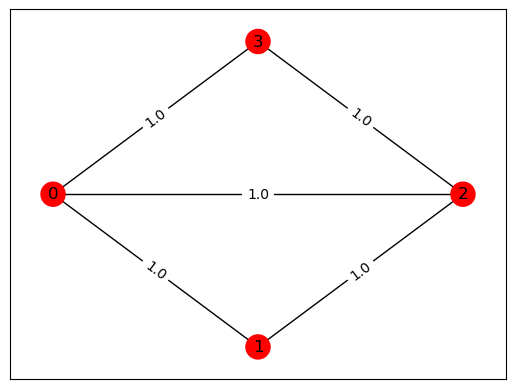

In [1]:
import networkx as nx

n = 4
G = nx.Graph()
G.add_nodes_from(range(n))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(edge_list)

colors = ["red" for i in range(n)]

def draw_graph(G, colors):
    """Dibuja el grafo con los colores elegidos"""
    layout = nx.shell_layout(G)
    nx.draw_networkx(G, node_color=colors, pos=layout)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

draw_graph(G, colors)

Para acceder cómodamente a los pesos del grafo, podemos utilizar la matriz de adyacencia del grafo. Esta matriz se puede obtener rápidamente con ``networkx.to_numpy_array``.

In [2]:
w = nx.to_numpy_array(G)
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


Esta matriz de adyacencia va a ser vital para obtener la función objetivo que vamos a utilizar.

¿Crees que la puedes deducir antes de pasar a la siguiente sección? Recuerda que queremos agrupar los nodos en **dos** grupos (no necesariamente con la misma cantidad de nodos) y buscamos maximizar la **suma** de los **pesos** de aquellas aristas que unan nodos de **distinto** grupo.

## Formulación matemática

Este problema se va a poder expresar como un problema de optimización binaria. 

Para cada nodo $0 \leq i < n$, donde $n$ es el número de nodos del grafo (en este caso $4$), vamos a considerar la variable binaria $x_i$, que valdrá $0$ si el nodo $i$ está en el grupo que llamaremos grupo $0$ y valdrá $1$ si está en el grupo $1$. Además, denotaremos como $w_{ij}$ al peso de la arista que une los nodos $i$ y $j$ y, al ser el grafo no dirigido, $w_{ij}=w_{ji}$. Entonces, podremos expresar el problema como la maximización de la siguiente función objetivo:

$$C(x)=\sum_{i,j=0}^n w_{ij} x_i(1-x_j) = \sum_{i,j=0}^n w_{ij} x_i - \sum_{i,j=0}^n w_{ij} x_ix_j = \sum_{i,j=0}^n w_{ij} x_i - \sum_{i=0}^n \sum_{j=0}^i 2w_{ij} x_ix_j $$

## Fuerza bruta

Antes de utilizar un ordenador cuántico para resolver el problema, vamos a hacerlo clásicamente. Para ello, vamos a considerar todas las asignaciones $[x_0,x_1,...,x_{n-1}]$ posibles y ver qué resultado obtenemos.

Como paso previo, consideraremos las siguientes funciones auxiliares:

In [3]:
import numpy as np

def bitfield(n, n_bits):
    """Obtiene la representación binaria como un array."""
    result = np.binary_repr(n, n_bits)
    return np.array([int(digit) for digit in result])

def objective_value(x, w):
    """Calcula el valor del corte."""
    X = np.outer(x, (1-x))
    return np.sum(w * X)

Ahora vamos a evaluar la función objetivo para cada combinación y buscar la que dé el mayor valor.

In [4]:
best_objective = 0

for candidate in range(2**n):
    x = bitfield(candidate, n)
    objective = objective_value(x, w)
    if objective > best_objective:
        best_objective = objective
        x_best = x
    print("case =", str(x), "cost =", str(objective))

print("\nBest solution =", str(x_best), "cost =", str(best_objective))

case = [0 0 0 0] cost = 0.0
case = [0 0 0 1] cost = 2.0
case = [0 0 1 0] cost = 3.0
case = [0 0 1 1] cost = 3.0
case = [0 1 0 0] cost = 2.0
case = [0 1 0 1] cost = 4.0
case = [0 1 1 0] cost = 3.0
case = [0 1 1 1] cost = 3.0
case = [1 0 0 0] cost = 3.0
case = [1 0 0 1] cost = 3.0
case = [1 0 1 0] cost = 4.0
case = [1 0 1 1] cost = 2.0
case = [1 1 0 0] cost = 3.0
case = [1 1 0 1] cost = 3.0
case = [1 1 1 0] cost = 2.0
case = [1 1 1 1] cost = 0.0

Best solution = [0 1 0 1] cost = 4.0


Obtenemos que $x_0=x_2=0$, $x_1=x_3=1$, es decir, los nodos $0$ y $2$ están en un grupo y los nodos $1$ y $3$ en el otro.

Veamos el resultado gráficamente.

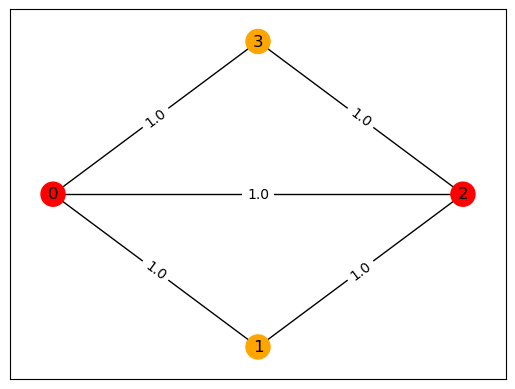

In [5]:
colors = ["red" if x_best[i] == 0 else "orange" for i in range(n)]
draw_graph(G, colors)

### Resolver Maxcut con Qiskit

El módulo Qiskit Optimization dispone de una clase llamada ``Maxcut`` que te permite definir un problema de corte máximo (ponderado) a partir de la matriz de adyacencia. A partir de ese problema, podemos obtener el problema de optimización binario que hemos deducido antes usando ``Maxcut.to_quadratic_program``.

In [6]:
from qiskit_optimization.applications import Maxcut

max_cut = Maxcut(w)

quadratic_program = max_cut.to_quadratic_program()
print(quadratic_program.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



Para resolver este problema con un ordenador cuántico, vamos a expresarlo como el valor esperado de un observable. Sin embargo, los observables que admite nativamente Qiskit son los operadores de Pauli, que en vez de valer $0$ o $1$ como las variables binarias, pueden valer $1$ o $-1$. Es por eso que vamos a realizar el siguiente cambio de variable a nuestra función:

$$z_i = 1-2x_i \rightarrow x_i = \frac{1-z_i}{2}$$

Esto implica que

$$ \begin{array}{lcl} x_i=0 & \rightarrow & z_i=1 \\ x_i=1 & \rightarrow & z_i=-1.\end{array}$$

Entonces la nueva función objetivo que vamos a maximizar pasa a ser:

$$C(z)=\sum_{i,j=0}^n w_{ij} \bigg(\frac{1-z_i}{2}\bigg)\bigg(1-\frac{1-z_j}{2}\bigg) \\=  \sum_{i,j=0}^n \frac{w_{ij}}{4} - \sum_{i,j=0}^n \frac{w_{ij}}{4} z_iz_j\\ = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} -  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} z_iz_j$$

Además, en un ordenador cuántico la tendencia natural es a minimizar el valor esperado del observable (habitualmente la energía del sistema), así que en vez de maximizar $C(z)$ minimizaremos

$$-C(z) =  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} z_iz_j -  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}$$

Ahora que tenemos una función objetivo a minimizar cuyas variables pueden tener valores $-1$ y $1$, podemos establecer la siguiente analogía con la puerta $Z$ de Pauli:

$$z_i \equiv Z_i = \overbrace{I}^{n-1}\otimes ... \otimes \overbrace{Z}^{i} \otimes ... \otimes \overbrace{I}^{0}$$

Es decir, estableceremos una equivalencia entre la variable $z_i$ y la puerta $Z$ actuando sobre el qubit $i$.

Entonces el observable que vamos a considerar es:

$$\hat{H} = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} Z_iZ_j,$$

al que luego añadiremos el término independiente:

$$ \texttt{offset} = - \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}$$

In [7]:
observable, offset = quadratic_program.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(observable))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


Antes de ejecutar utilizar computación cuántica para resolver este problema, veamos si el autoestado de menor autovalor de nuestro observable es efectivamente
la solución del problema. Para ello, utilizaremos el algoritmo clásico del ``NumPyMinimumEigensolver``.

In [8]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
numpy_result = numpy_solver.compute_minimum_eigenvalue(observable)

print(numpy_result)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)),
    'eigenvalue': (-1.5+0j)}


Los valores de un ``Statevector`` están ordenados de tal manera que el elemento con índice $i$ corresponde al estado $|i\rangle$, por lo que el resultado que obtenemos aquí es $$|5\rangle \equiv |0101\rangle$$

Vamos a interpretar este resultado.

energy: -1.5
max-cut objective: -4.0
solution: [1. 0. 1. 0.]
solution objective: 4.0


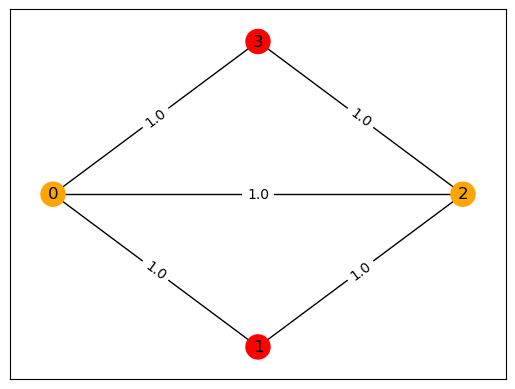

In [9]:
x = max_cut.sample_most_likely(numpy_result.eigenstate)
print("energy:", numpy_result.eigenvalue.real)
print("max-cut objective:", numpy_result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", quadratic_program.objective.evaluate(x))

colors = ["red" if x[i] == 0 else "orange" for i in range(n)]
draw_graph(G, colors)

Fijaos en que el orden de la solución del Maxcut es el inverso al del estado cuántico que hemos obtenido. Esto se debe a que el orden de los qubits en Qiskit es little-endian $(q_{n-1}\otimes ... \otimes q_0)$ mientras que el orden que hemos utilizado para los nodos es big-endian $([x_0,...,x_{n-1}])$.

Ahora vamos a calcular el menor autovalor con computación cuántica. En concreto utilizaremos el VQE (Variational Quantum Eigensolver).

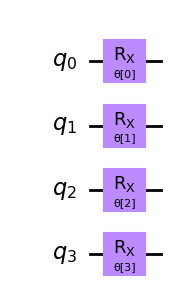

{   'aux_operators_evaluated': None,
    'cost_function_evals': 91,
    'eigenvalue': -1.4999999958891217,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fc709a38dc0>,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -6.777333688103943e-05,
                              ParameterVectorElement(θ[2]): 3.1415966260626993,
                              ParameterVectorElement(θ[0]): 3.1416777333348884,
                              ParameterVectorElement(θ[3]): -1.16602660655017e-06},
    'optimal_point': array([ 3.14167773e+00, -6.77733369e-05,  3.14159663e+00, -1.16602661e-06]),
    'optimal_value': -1.4999999958891217,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fc70b3c84c0>,
    'optimizer_time': 0.16884994506835938}


In [10]:
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal


ansatz = TwoLocal(observable.num_qubits, "rx", reps=1, skip_final_rotation_layer=True)
display(ansatz.decompose().draw("mpl"))

optimizer = COBYLA()

vqe = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=optimizer, initial_point=np.zeros(ansatz.num_parameters))

# run VQE
result = vqe.compute_minimum_eigenvalue(observable)

print(result)

Ahora que tenemos los valores óptimos de los parámetros, vamos a obtener el estado. Para ello definimos la siguiente función.

In [11]:
from qiskit.quantum_info import Statevector

def get_statevector(result):
    """Obtiene el estado óptimo a partir de los resultados"""
    #  asignamos los valores de los parámetros al circuito (parametrizado) óptimo
    optimal_circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)
    # definimos el vector del estado
    optimal_vector = Statevector.from_instruction(optimal_circuit)
    return optimal_vector

Ahora veamos el qué aspecto tiene el estado obtenido con VQE.

In [12]:
statevector = get_statevector(result)

with np.printoptions(precision=9, suppress=True):
    print(statevector.data)

[ 0.         +0.j           0.         +0.000001986j
  0.         +0.j          -0.         +0.j
  0.         +0.00004254j  -0.999999999+0.j
 -0.000000001+0.j           0.         -0.000033887j
  0.         +0.j          -0.         +0.j
 -0.         +0.j           0.         -0.j
 -0.         +0.j           0.         -0.000000583j
  0.         -0.j           0.         +0.j         ]


Para hacerlo más visual, vamos a convertir los coeficientes del estado en probabilidades y representar el histograma con ``plot_histogram``.

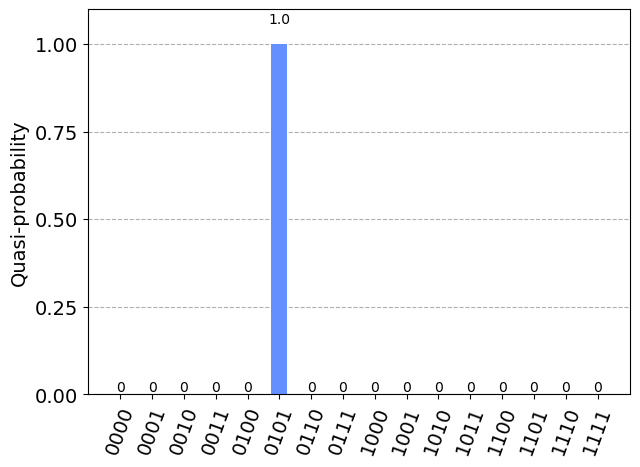

In [13]:
from qiskit.visualization import plot_histogram

dict = {}
for index, amplitude in zip(range(2**n), statevector.data):
    dict[str(np.binary_repr(index, n))] = np.abs(amplitude)**2

plot_histogram(dict)

energy: -1.4999999958891217
time: 0.16884994506835938
max-cut objective: -3.9999999958891217
solution: [1. 0. 1. 0.]
solution objective: 4.0


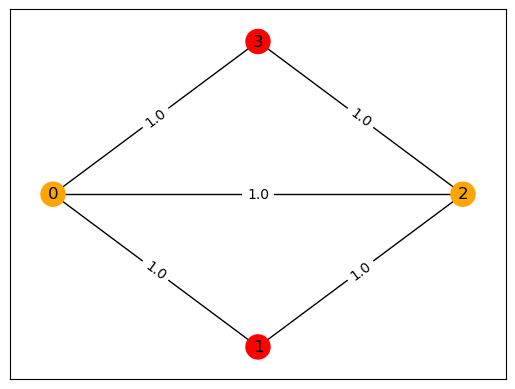

In [14]:
x = max_cut.sample_most_likely(get_statevector(result))
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", quadratic_program.objective.evaluate(x))

# plot results
colors = ["red" if x[i] == 0 else "orange" for i in range(n)]
draw_graph(G, colors)

En este notebook hemos visto cómo podemos resolver el problema del corte máximo o Max-Cut con computación cuántica. 